In [9]:
import os
import shutil
import random
from PIL import Image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.regularizers import l2, l1
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint

path = '/notebook/CJ/'
HOME_DIR = path+'fed_detect/'
DATA_DIR = HOME_DIR+'fr_graphics/'
RESULTS_DIR = DATA_DIR+'results/'
TRAIN_DIR = HOME_DIR+'fr_graphics/train/'
VAL_DIR = HOME_DIR+'fr_graphics/valid/'
TEST_DIR = HOME_DIR+'fr_graphics/test/'

Show number of files in training/validation directories

In [2]:
train_class_folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))]) # Get all directories 
val_class_folders = ([name for name in os.listdir(VAL_DIR)
            if os.path.isdir(os.path.join(VAL_DIR, name))])

train_content_len = []
for folder in train_class_folders:
    contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
    train_content_len.append(len(contents))
    print(os.path.join(TRAIN_DIR,folder),str(len(contents))+' files')
    
val_content_len = []
for folder in val_class_folders:
    contents = os.listdir(os.path.join(VAL_DIR,folder)) # Get list of contents
    val_content_len.append(len(contents))
    print(os.path.join(VAL_DIR,folder),str(len(contents))+' files')

('/notebook/CJ/fed_detect/fr_graphics/train/tables', '1321 files')
('/notebook/CJ/fed_detect/fr_graphics/train/text', '317 files')
('/notebook/CJ/fed_detect/fr_graphics/train/maps', '292 files')
('/notebook/CJ/fed_detect/fr_graphics/train/forms', '114 files')
('/notebook/CJ/fed_detect/fr_graphics/train/graphs', '174 files')
('/notebook/CJ/fed_detect/fr_graphics/train/diagram', '240 files')
('/notebook/CJ/fed_detect/fr_graphics/train/equations', '626 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/tables', '330 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/text', '78 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/maps', '72 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/forms', '28 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/graphs', '43 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/diagram', '60 files')
('/notebook/CJ/fed_detect/fr_graphics/valid/equations', '156 files')


Make sure validation directories exist (else create them)

In [4]:
if len(val_class_folders)==0:
    for folder in train_class_folders:
        os.mkdir(os.path.join(VAL_DIR,folder))
        print('Making directory: '+os.path.join(VAL_DIR,folder))

Enforce training/validation split

In [5]:
validation_split = 0.2

# Check difference between number of files in training v. validation set
target_val_size = [int((x+y)*validation_split) for x,y in zip(train_content_len,val_content_len)]
split_diff = [int(abs(x-y)) for x,y in zip(val_content_len,target_val_size)]

# Enforce train/validate split
if any(t!=0 for t in split_diff):
    
    for i,folder in enumerate(train_class_folders):
        contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
            
        # In-place shuffle
        random.shuffle(contents)
        
        print('Moving '+str(split_diff[i])+' files')
        
        for file_name in contents[:split_diff[i]]:
            full_file_name = os.path.join(TRAIN_DIR, folder, file_name)
            
            if (os.path.isfile(full_file_name)):
                #shutil.move(full_file_name, os.path.join(VAL_DIR, folder))
                pass

Moving 0 files
Moving 1 files
Moving 0 files
Moving 0 files
Moving 0 files
Moving 0 files
Moving 0 files


Plot examples of each class of input image (and save figure to .png)

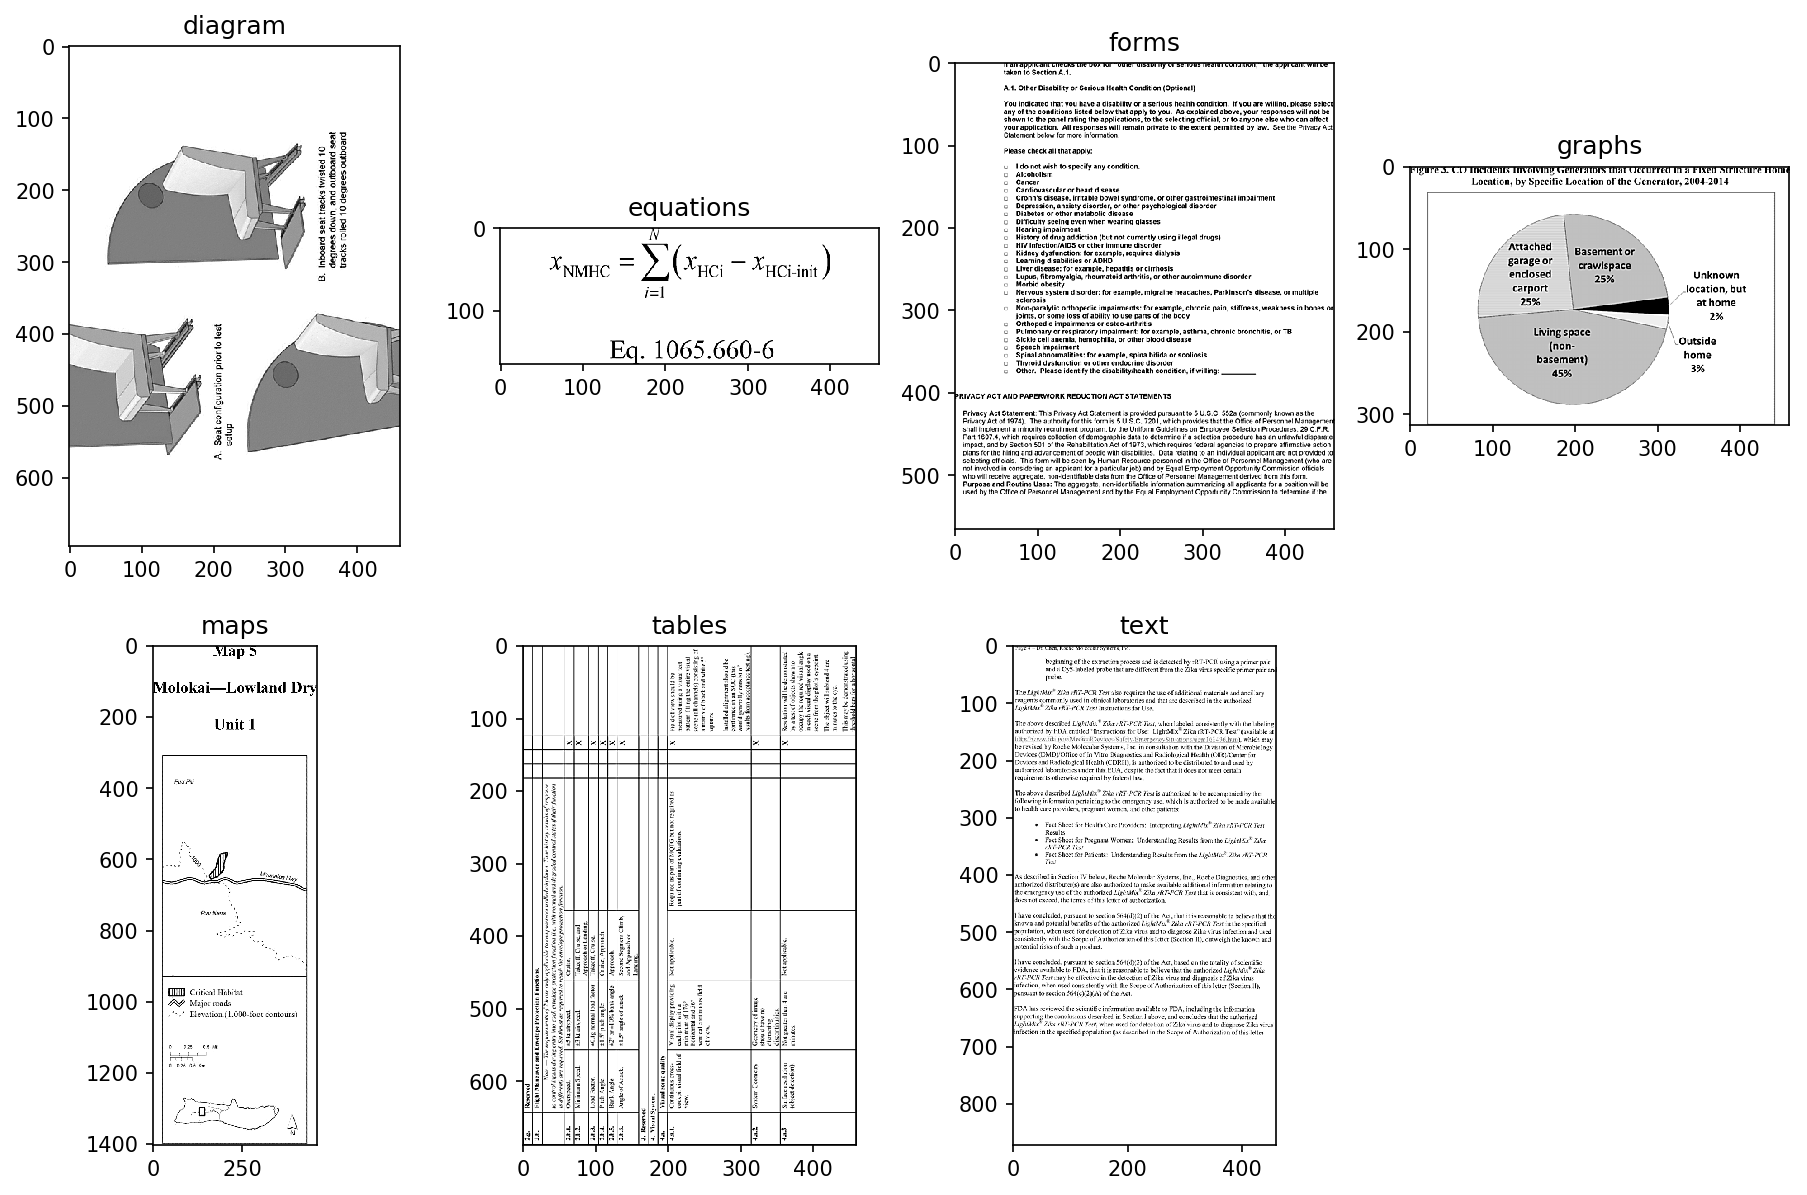

In [6]:
%matplotlib inline

fig = plt.figure(figsize=(15, 15), dpi=150)

path = TRAIN_DIR

for i,folder in enumerate(sorted(train_class_folders)):
    
    ax = fig.add_subplot(3, 4, i+1) # Add sub-axes

    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    
    # Show image from each class 
    ax.set_title(folder)
    ax.imshow(Image.open(os.path.join(path,folder)+'/'+contents[0])) # this line creates the image using the pre-defined sub axes

fig.savefig(RESULTS_DIR+'training_class_examples.png')


Define model parameters

In [66]:
batch_size = 32
epoch_count = 3
input_shape = (256,256,3)
valid_steps = 75 # Validation steps
output_dim = len(train_class_folders) # n-way categorical classification task

learning_rate = 1e-4
decay_rate = learning_rate / epoch_count

Use ImageDataGenerator to read images from directories

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Rescale images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.05, rotation_range=10,
                channel_shift_range=10, height_shift_range=0.03, width_shift_range=0.05)  
                #rotation_range=15, height_shift_range=0.05, 
                #shear_range=0.1, channel_shift_range=20, width_shift_range=0.1
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(     
    TRAIN_DIR,  # Target directory   
    shuffle=True,       
    target_size=input_shape[:-1],
    batch_size=batch_size,       
    class_mode='categorical'
    )
valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='categorical'
    )
test_generator = valid_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='categorical'
    )

Found 3082 images belonging to 7 classes.
Found 767 images belonging to 7 classes.
Found 6893 images belonging to 1 classes.


In [5]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

('data batch shape:', (32, 256, 256, 3))
('labels batch shape:', (32, 7))


In [6]:
def plot_save_history(history, savename):
    fig = plt.figure()
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    
    ax = fig.add_subplot(2, 1, 1) # Add sub-axes
    ax.plot(epochs, acc, 'b')
    ax.plot(epochs, val_acc, 'bo')
    ax.set_title('Training and validation accuracy')
    
    ax = fig.add_subplot(2, 1, 2) # Add sub-axes
    ax.plot(epochs, loss, 'b')
    ax.plot(epochs, val_loss, 'bo')
    ax.set_title('Training and validation loss')
    plt.show()
    fig.savefig(savename) # , figsize=(5, 5), dpi=150

In [53]:
from keras.callbacks import LearningRateScheduler
import math

decay_rate = learning_rate / epoch_count

# learning rate schedule
def step_decay(epoch):
    initial_lrate = learning_rate #0.01
    drop = 0.5
    #epochs_drop = 10.0
    epochs_drop = epoch_count
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

Generate classifier model

In [50]:
lin_model = Sequential([
        BatchNormalization(axis=1, input_shape=input_shape),
        Flatten(),
        Dense(output_dim, activation='softmax') # kernel_regularizer=l2(0.01)
    ])

lin_model.compile(optimizer=RMSprop(lr=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

lin_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_19 (Batc (None, 256, 256, 3)       1024      
_________________________________________________________________
flatten_19 (Flatten)         (None, 196608)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 1376263   
Total params: 1,377,287
Trainable params: 1,376,775
Non-trainable params: 512
_________________________________________________________________


Fit our model using batch generator

Epoch 1/5
96/96 [==============================] - 55s - loss: 1.7592 - acc: 0.4205 - val_loss: 1.8231 - val_acc: 0.3331
Epoch 2/5
96/96 [==============================] - 50s - loss: 1.5451 - acc: 0.4952 - val_loss: 1.5439 - val_acc: 0.4639
Epoch 3/5
96/96 [==============================] - 50s - loss: 1.4816 - acc: 0.5133 - val_loss: 1.5249 - val_acc: 0.4723
Epoch 4/5
96/96 [==============================] - 50s - loss: 1.4585 - acc: 0.5283 - val_loss: 1.5169 - val_acc: 0.5169
Epoch 5/5
96/96 [==============================] - 50s - loss: 1.4338 - acc: 0.5453 - val_loss: 1.4032 - val_acc: 0.5440


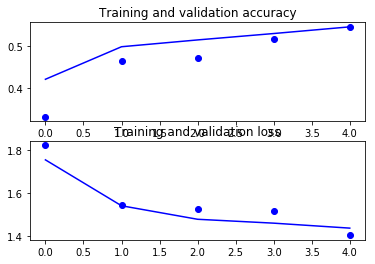

In [51]:
history = lin_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps
    )

# Save model
lin_model.save_weights(os.path.join(RESULTS_DIR,'lin_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'lin_model.png'))

# loss: 7.2002 - acc: 0.5415 - val_loss: 6.8459 - val_acc: 0.565

Epoch 1/5
96/96 [==============================] - 108s - loss: 1.1874 - acc: 0.6390 - val_loss: 2.9886 - val_acc: 0.1644
Epoch 2/5
96/96 [==============================] - 108s - loss: 0.6970 - acc: 0.7861 - val_loss: 2.0718 - val_acc: 0.3154
Epoch 3/5
96/96 [==============================] - 108s - loss: 0.5463 - acc: 0.8289 - val_loss: 0.9137 - val_acc: 0.6767
Epoch 4/5
96/96 [==============================] - 108s - loss: 0.4648 - acc: 0.8533 - val_loss: 0.4569 - val_acc: 0.8861
Epoch 5/5
96/96 [==============================] - 108s - loss: 0.3907 - acc: 0.8766 - val_loss: 0.4550 - val_acc: 0.8765


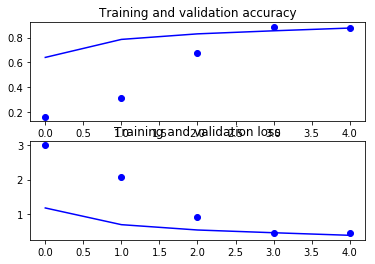

In [55]:
conv_model = Sequential([
            BatchNormalization(axis=1, input_shape=input_shape),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dropout(0.5),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dense(output_dim, activation='softmax')
        ])

conv_model.compile(optimizer=Adam(lr=1e-4, decay=1e-4/10), # , decay=1e-4/100
                loss='categorical_crossentropy',
                metrics=['accuracy']
                  )

history = conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps
                   )

# Save model
conv_model.save(os.path.join(RESULTS_DIR,'conv_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'conv_model.png'))

# loss: 0.3975 - acc: 0.8750 - val_loss: 0.3563 - val_acc: 0.9023

Instantiate the VGG16 convolutional base

In [56]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base.trainable = False # Freeze the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Add a densely-connected classifier on top of the convolutional base

In [60]:
pt_froz_conv_model = Sequential()
pt_froz_conv_model.add(conv_base)
pt_froz_conv_model.add(Flatten())
pt_froz_conv_model.add(Dense(256, activation='relu'))
pt_froz_conv_model.add(Dense(output_dim, activation='softmax')) # activation='sigmoid'

pt_froz_conv_model.summary()

pt_froz_conv_model.compile(optimizer=Adam(lr=1e-4, decay=1e-4/10), # , decay=decay_rate # Adam(lr=1e-3), RMSprop
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history = pt_froz_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps
                   )

# Save model
pt_froz_conv_model.save_weights(os.path.join(RESULTS_DIR,'pt_froz_conv_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'pt_froz_conv_model.png'))

#RMSprop loss: 0.2577 - acc: 0.9264 - val_loss: 0.3782 - val_acc: 0.9157
#Adam loss: 0.1267 - acc: 0.9592 - val_loss: 0.1841 - val_acc: 0.9537

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_33 (Dense)             (None, 7)                 1799      
Total params: 23,105,351
Trainable params: 8,390,663
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/5
96/96 [==============================] - 92s - loss: 0.2141 - acc: 0.9338 - val_loss: 0.2011 - val_acc: 0.9570
Epoch 2/5
96/96 [==============================] - 92s - loss: 0.1045 - acc: 0.9674 - val_loss: 0.2563 - val_acc: 0.9353
Epoch 3/5
 8

KeyboardInterrupt: 

In [64]:
# Un-freeze the convolutional base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:        
        layer.trainable = False

Pre-trained convolutional network, partially un-frozen convolutional base

Epoch 1/3
96/96 [==============================] - 62s - loss: 0.1203 - acc: 0.9590 - val_loss: 0.1455 - val_acc: 0.9741
Epoch 2/3
96/96 [==============================] - 57s - loss: 0.0310 - acc: 0.9919 - val_loss: 0.1662 - val_acc: 0.9795
Epoch 3/3
96/96 [==============================] - 57s - loss: 0.0352 - acc: 0.9885 - val_loss: 0.2356 - val_acc: 0.9654


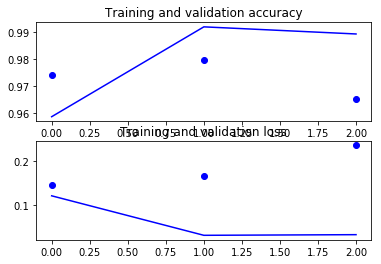

In [69]:
pt_conv_model = Sequential()
pt_conv_model.add(conv_base)
pt_conv_model.add(Flatten())
pt_conv_model.add(Dense(256, activation='relu'))
pt_conv_model.add(Dense(output_dim, activation='softmax')) # , kernel_regularizer=l2(0.01)

pt_conv_model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

## Create learning schedule callback
#lrate = LearningRateScheduler(step_decay)
#callbacks_list = [lrate]

history = pt_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps #, callbacks=callbacks_list
                   )

# Save model
pt_conv_model.save_weights(os.path.join(RESULTS_DIR,'pt_conv_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'pt_conv_model.png'))

# Adam loss: 0.0343 - acc: 0.9909 - val_loss: 0.1825 - val_acc: 0.9691

Pre-trained convolutional network with drop-out, partially un-frozen convolutional base

In [ ]:
# Add drop-out
pt_dr_conv_model = Sequential()
pt_dr_conv_model.add(conv_base)
pt_dr_conv_model.add(Flatten())
pt_dr_conv_model.add(Dropout(0.5))
pt_dr_conv_model.add(Dense(256, activation='relu'))
pt_dr_conv_model.add(Dense(output_dim,
                           activation='softmax',
                           kernel_regularizer=l2(0.01))) # activation='sigmoid'

pt_dr_conv_model.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps)

# Save model weights
pt_dr_conv_model.save(os.path.join(RESULTS_DIR,'pt_dr_conv_model.h5'))
#pt_dr_conv_model.save_weights(os.path.join(RESULTS_DIR,'pt_dr_conv_weights.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR, 'pt_dr_conv_model.png'))

# loss: 0.1379 - acc: 0.9883 - val_loss: 0.4270 - val_acc: 0.9578

# loss: 9.0709 - acc: 0.4372 - val_loss: 9.1720 - val_acc: 0.4310

In [7]:
from keras.models import load_model

# Load a compiled model (identical to the previous one)
model = load_model(os.path.join(RESULTS_DIR,'pt_dr_conv_model.h5'))

## Load model weights
#pt_dr_conv_model.load_weights(os.path.join(RESULTS_DIR,'pt_dr_conv_weights.h5'))

### Visualize convnet filters

In [8]:
pt_dr_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2827      
Total params: 23,106,379
Trainable params: 8,391,691
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
from keras import backend as K

model = pt_dr_conv_model

# Define the loss tensor for filter visualization
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor
grads = K.gradients(loss, model.input)[0] # Add 1e-5 before dividing so as to avoid accidentally dividing by 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [10]:
# Define a Keras function for fetching Numpy output values, given Numpy input values
iterate = K.function([model.input], [loss, grads])

# Maximize loss via stochastic gradient descent over the input parameters
# We start from a gray image with some noise
input_img_data = np.random.random((1,)+input_shape) * 20 + 128.
# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step
    
# Utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=input_shape[0]):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

## Show example filter
#plt.imshow(generate_pattern('block3_conv1', 0))
#plt.show()

Generate grid of all filter response patterns in a layer

In [17]:
def plot_filters(layer_name):
    size = input_shape[0]
    margin = 5
    rows = 6
    cols = 6

    # Create an empty (black) image where we will store our results
    results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3))
    for i in range(rows):
        # Iterate over the rows of our results grid
        for j in range(cols):
            # Iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * cols), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [18]:
layer_name = 'block1_conv1'
plot_filters(layer_name)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [19]:
layer_name = 'block1_conv2'
plot_filters(layer_name)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
layer_name = 'block2_conv1'
plot_filters(layer_name)

In [ ]:
layer_name = 'block3_conv1'
plot_filters(layer_name)

In [ ]:
layer_name = 'block4_conv1'
plot_filters(layer_name)

In [ ]:
layer_name = 'block5_conv1'
plot_filters(layer_name)

In [ ]:
layer_name = 'block5_conv2'
plot_filters(layer_name)

In [ ]:
layer_name = 'block5_conv3'
plot_filters(layer_name)

### Generate confusion matrix

Found 767 images belonging to 7 classes.


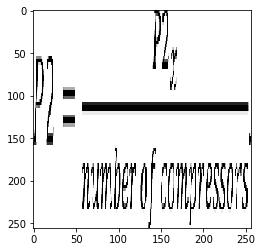

Actual class: equations
Predicted class: equations


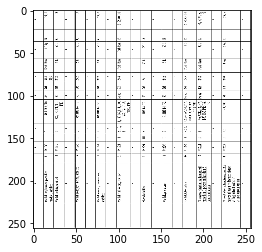

Actual class: tables
Predicted class: tables


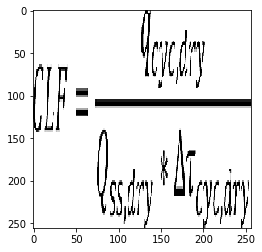

Actual class: equations
Predicted class: equations


In [23]:
conf_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=128,
    class_mode='categorical'
    )

for i in range(0, 3):
    # Test out classifier
    inverted_dict = dict([[v,k] for k,v in conf_generator.class_indices.items()])

    im_vals,class_val = conf_generator.next()
    predictions = pt_dr_conv_model.predict(im_vals)

    # Show image
    plt.imshow(im_vals[i])
    plt.show()

    y_test = np.argmax(class_val, axis=1)
    y_pred = np.argmax(predictions, axis=1)

    # Show actual category
    category_val = inverted_dict[y_test[i]]
    print('Actual class: '+category_val)

    # Show predicted category
    class_preds = inverted_dict[y_pred[i]]
    print('Predicted class: '+class_preds)

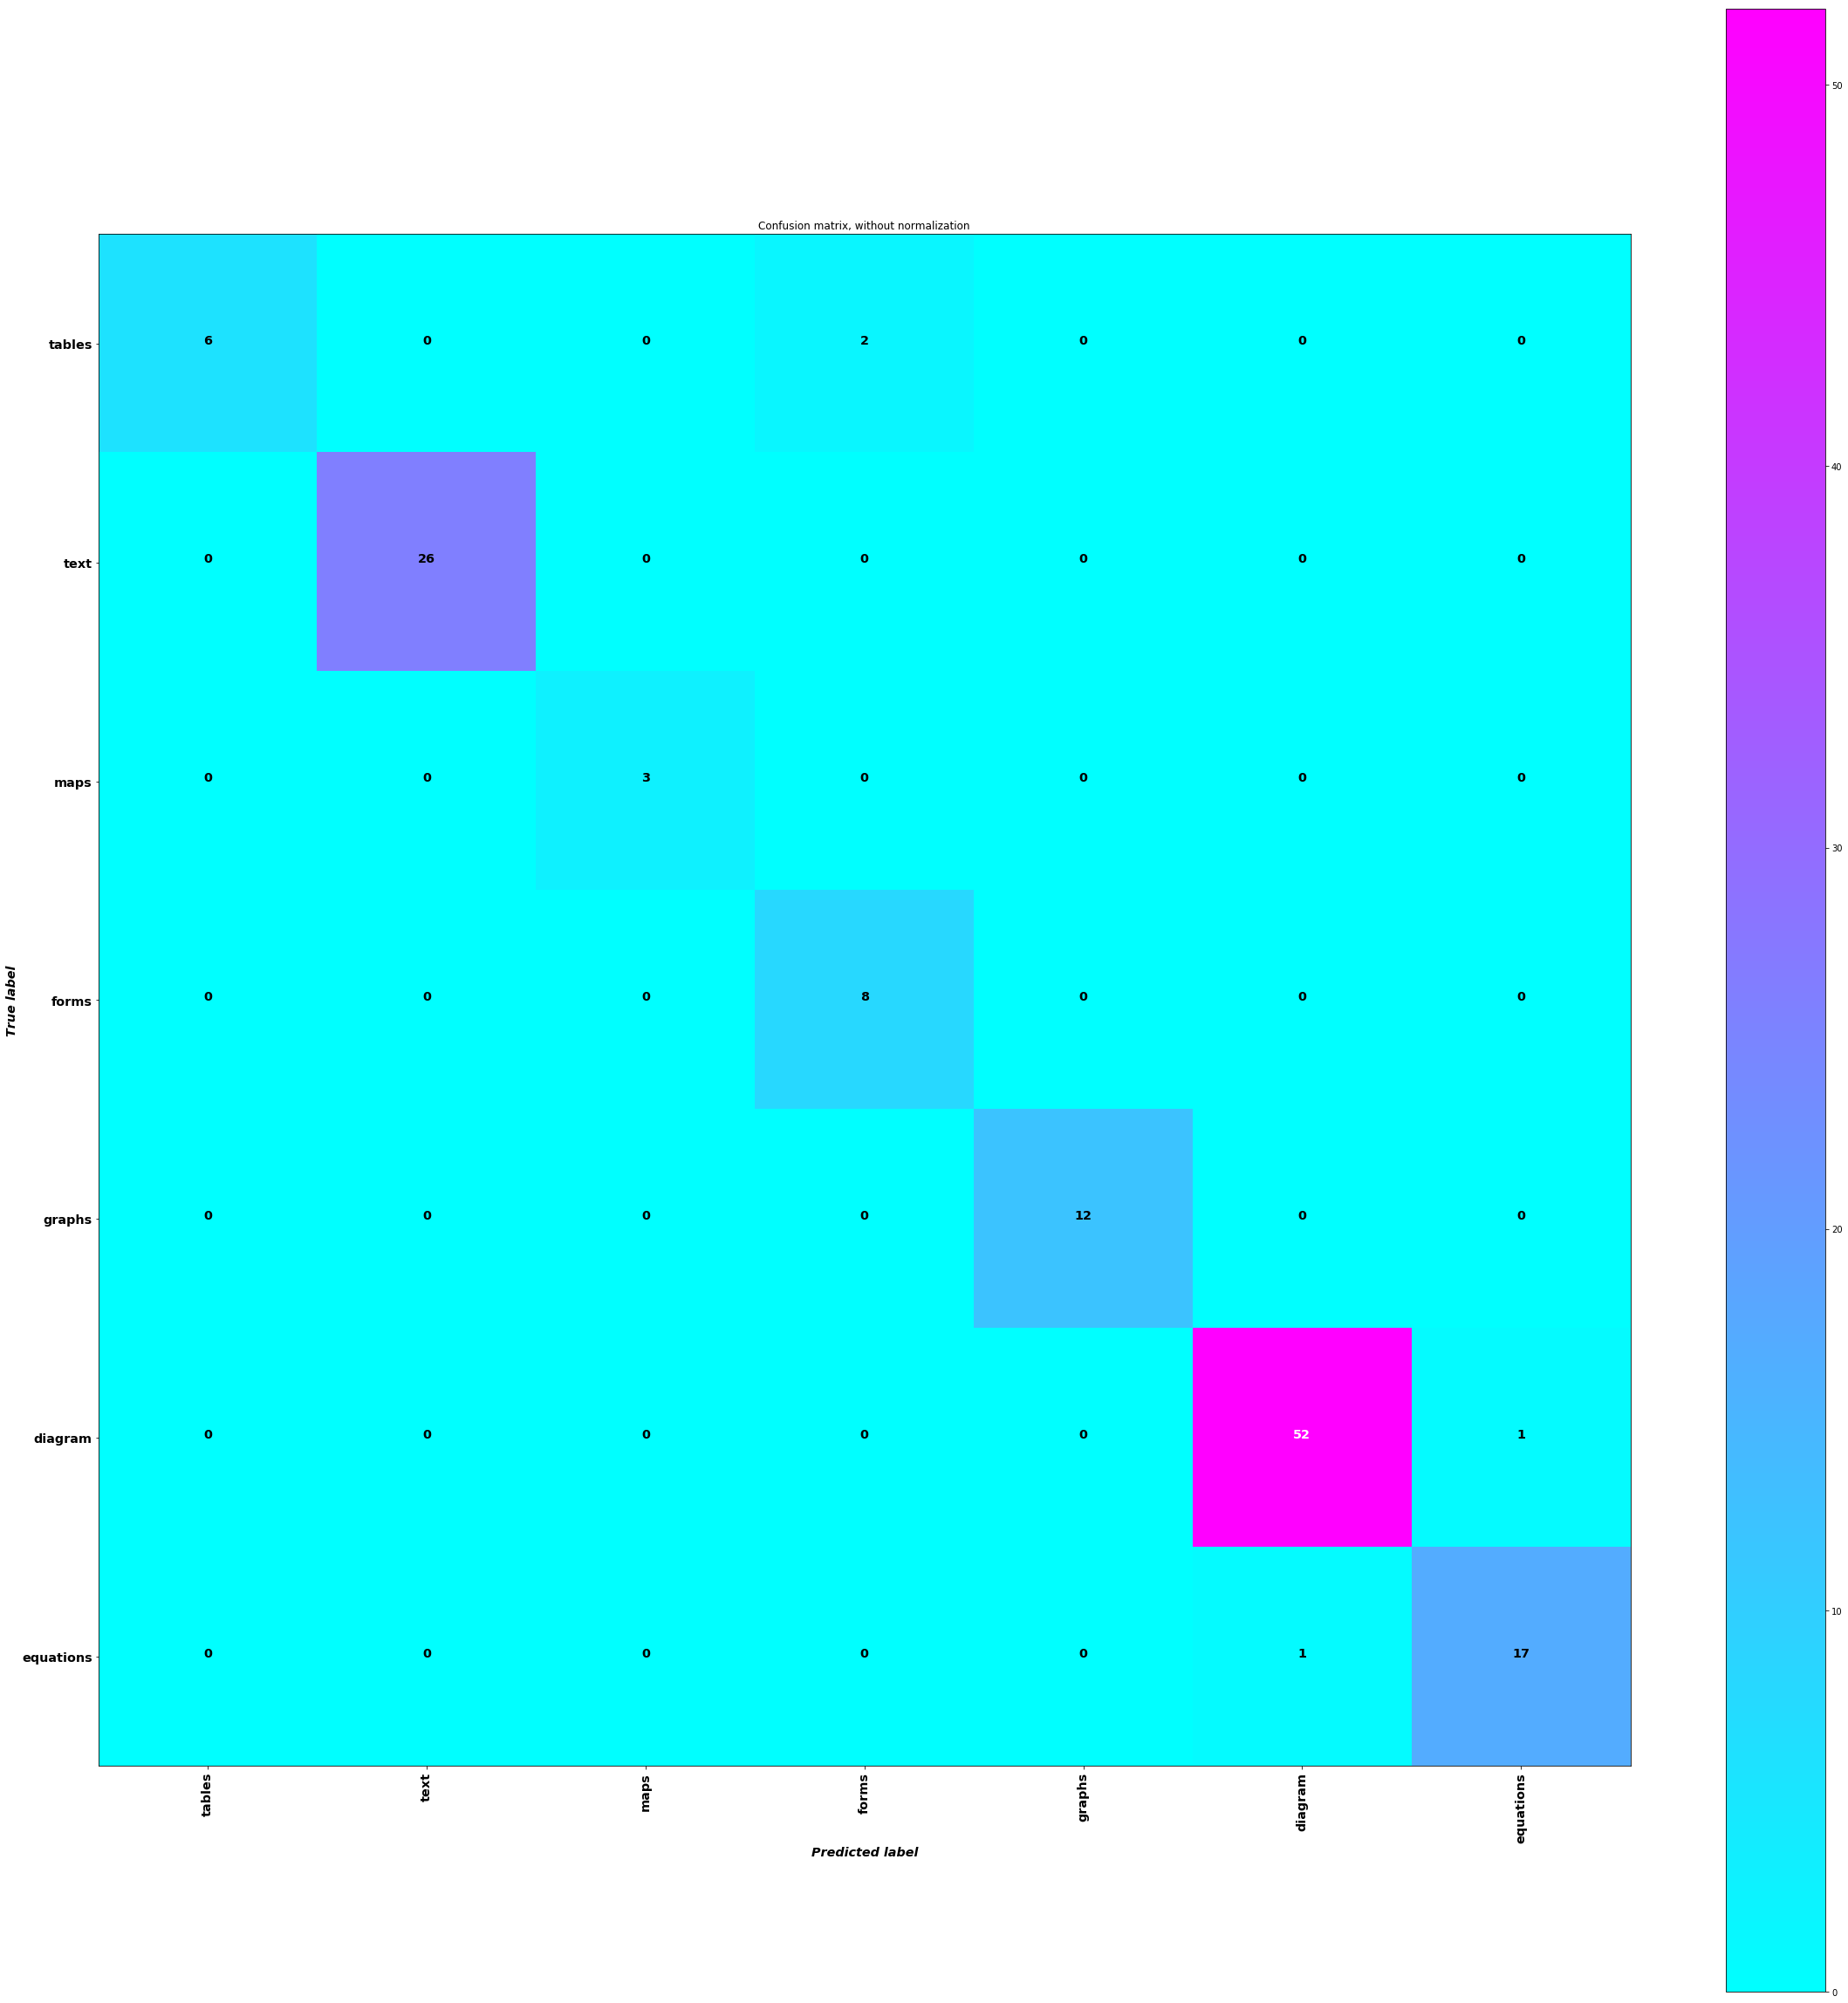

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size='x-large', weight='bold')
    plt.yticks(tick_marks, classes, size='x-large', weight='bold')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], #  "%.3f" % 
                 horizontalalignment="center",
                 size="x-large",
                 weight="bold",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size='x-large', weight='bold', style='italic')
    plt.xlabel('Predicted label', size='x-large', weight='bold', style='italic')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=train_class_folders,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.show()
fig.savefig(RESULTS_DIR+'conf_matrix.png')

In [62]:
np.sum(cnf_matrix,axis=0)

array([ 29,  21,  12, 134,  34,  42,  66, 160, 170,  35,  32])